In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

import medmnist
from medmnist import INFO, Evaluator

# Data Preparation

In [2]:
print(medmnist.__version__)
# note there is also mednist+!!

3.0.2


In [3]:
from medmnist import BreastMNIST

train_dataset = BreastMNIST(split='train', download=True)
test_dataset  = BreastMNIST(split='test', download=True)

Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz


In [4]:
train_dataset.info

{'python_class': 'BreastMNIST',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1',
 'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1',
 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364',
 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1',
 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1',
 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1',
 'MD5_224

Note: normal + benign are combined into one class: benign!

In [5]:
print(len(train_dataset))

546


## Convert medmnist datset object into pandas dataframe

In [6]:
# save images and labels in a list
images = []
labels = []

for img, label in train_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [7]:
# create a df of the extracted data
train_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [8]:
train_df.head()

,image,label
0,"[[139, 139, 138, 139, 142, 149, 156, 159, 164,...",1
1,"[[82, 85, 83, 78, 76, 76, 79, 79, 76, 80, 86, ...",1
2,"[[157, 155, 151, 145, 149, 146, 141, 134, 141,...",1
3,"[[167, 163, 162, 151, 145, 133, 139, 149, 150,...",1
4,"[[1, 6, 41, 79, 159, 180, 175, 175, 175, 181, ...",0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   546 non-null    object
 1   label   546 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [10]:
train_df["label"].value_counts()

label
1    399
0    147
Name: count, dtype: int64

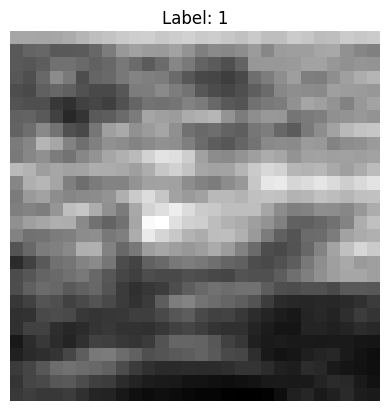

In [11]:
# define a sample
sample = train_df.iloc[0]

img_np = sample["image"] 
label  = sample["label"]

plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [12]:
print("shape:",img_np.shape)

shape: (28, 28)


In [13]:
# save images and labels in a list
images = []
labels = []

for img, label in test_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [14]:
# create a df of the extracted data
test_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

In [16]:
# device definition: gpu/ cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [17]:
X_train = np.stack(train_df['image'].values)
y_train = np.array(train_df['label'].values)

X_test = np.stack(test_df['image'].values)
y_test = np.array(test_df['label'].values)

In [18]:
X_train.shape

(546, 28, 28)

In [19]:
X_train.shape

(546, 28, 28)

In [20]:
# PCA expects array of dim 2 as input --> flatten the 28x28 matrix to 784 features
X_train_flat = X_train.reshape(X_train.shape[0], -1) # X_train.shape[0] keeps number of samples, -1 flattens everything else in one long vector
X_test_flat  = X_test.reshape(X_test.shape[0], -1)
X_train_flat.shape

(546, 784)

In [21]:
# Apply PCA
n_features = 8
pca = PCA(n_components=n_features)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca  = pca.transform(X_test_flat)

In [22]:
print(X_train_pca.shape)  # (546, 8)
print(X_test_pca.shape)   # (whatever test samples, 8)

(546, 8)
(156, 8)


In [22]:
# convert X,y into torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y__train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

In [23]:
# Convert to tensors
X_train_t = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

# QCNN Approach 1

In [24]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

at this stage, the images are flattened 8 most important features = 8 qubits

Angle encoding is a powerful technique for representing classical data in quantum states. By leveraging the angles of rotation gates applied to qubits, angle encoding allows to encode classical information in quantum states. 

In [26]:
n_qubits = n_features

def angle_encoding(qc, x):
    """Encode classical data using RY rotations"""
    for i in range(n_qubits): # loop through each qubit
        qc.ry(x[i],i) # apply RY (rotation around y-axis) gate to qubit i, rotation angle is x[i]

In [27]:
# create a quantum circuit instance
qc = QuantumCircuit(n_qubits)

# define the input parameters
input_params = []
for i in range(n_qubits):
    parameter = Parameter(f"x{i}")  # create placeholder parameters
    input_params.append(parameter)

theta_params = []
for i in range(n_qubits):
    param = Parameter(f'θ{i}') # create placeholders for weights that can be adjusted
    theta_params.append(param)

print(qc)


     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
q_5: 
     
q_6: 
     
q_7: 
     


In [28]:
# Angle encoding layer: RY rotations with input data
for i in range(n_qubits):
    qc.ry(input_params[i], i) # encode data in quantum states
print(qc)

     ┌────────┐
q_0: ┤ Ry(x0) ├
     ├────────┤
q_1: ┤ Ry(x1) ├
     ├────────┤
q_2: ┤ Ry(x2) ├
     ├────────┤
q_3: ┤ Ry(x3) ├
     ├────────┤
q_4: ┤ Ry(x4) ├
     ├────────┤
q_5: ┤ Ry(x5) ├
     ├────────┤
q_6: ┤ Ry(x6) ├
     ├────────┤
q_7: ┤ Ry(x7) ├
     └────────┘


In [29]:
# Variational layer: trainable RX rotations
for i in range(n_qubits):
    qc.rx(theta_params[i], i) # create placeholders for weights that can be adjusted

print(qc)

     ┌────────┐┌────────┐
q_0: ┤ Ry(x0) ├┤ Rx(θ0) ├
     ├────────┤├────────┤
q_1: ┤ Ry(x1) ├┤ Rx(θ1) ├
     ├────────┤├────────┤
q_2: ┤ Ry(x2) ├┤ Rx(θ2) ├
     ├────────┤├────────┤
q_3: ┤ Ry(x3) ├┤ Rx(θ3) ├
     ├────────┤├────────┤
q_4: ┤ Ry(x4) ├┤ Rx(θ4) ├
     ├────────┤├────────┤
q_5: ┤ Ry(x5) ├┤ Rx(θ5) ├
     ├────────┤├────────┤
q_6: ┤ Ry(x6) ├┤ Rx(θ6) ├
     ├────────┤├────────┤
q_7: ┤ Ry(x7) ├┤ Rx(θ7) ├
     └────────┘└────────┘


This represents the trainable part.
Rotating each qubit by a learned amount (theta angles). RX= rotation around the x-axis. After the inital data rotation, apply a second rotation. The model learns the second rotation! 

In [30]:
# Entanglement layer: CNOT gates
for i in range(n_qubits - 1):
    qc.cx(i, i+1)

print(qc)

     ┌────────┐┌────────┐                                   
q_0: ┤ Ry(x0) ├┤ Rx(θ0) ├──■────────────────────────────────
     ├────────┤├────────┤┌─┴─┐                              
q_1: ┤ Ry(x1) ├┤ Rx(θ1) ├┤ X ├──■───────────────────────────
     ├────────┤├────────┤└───┘┌─┴─┐                         
q_2: ┤ Ry(x2) ├┤ Rx(θ2) ├─────┤ X ├──■──────────────────────
     ├────────┤├────────┤     └───┘┌─┴─┐                    
q_3: ┤ Ry(x3) ├┤ Rx(θ3) ├──────────┤ X ├──■─────────────────
     ├────────┤├────────┤          └───┘┌─┴─┐               
q_4: ┤ Ry(x4) ├┤ Rx(θ4) ├───────────────┤ X ├──■────────────
     ├────────┤├────────┤               └───┘┌─┴─┐          
q_5: ┤ Ry(x5) ├┤ Rx(θ5) ├────────────────────┤ X ├──■───────
     ├────────┤├────────┤                    └───┘┌─┴─┐     
q_6: ┤ Ry(x6) ├┤ Rx(θ6) ├─────────────────────────┤ X ├──■──
     ├────────┤├────────┤                         └───┘┌─┴─┐
q_7: ┤ Ry(x7) ├┤ Rx(θ7) ├──────────────────────────────┤ X ├
     └────────┘└────────

Introduce entanglement by appling cnot-gates. This creates quantum correlations.
Qubits become correlated in ways that can not be achieved by classical bits. This allows the circuit
to find complex patterns in the data. 

In [31]:
class QiskitQuantumLayer(nn.Module):
    def __init__(self, n_qubits, quantum_circuit, input_params, theta_params):
        super().__init__()
        self.n_qubits = n_qubits
        self.qc = quantum_circuit
        self.input_params = input_params
        self.theta_params = theta_params

        # Trainable parameters
        self.params = nn.Parameter(torch.randn(n_qubits))

        # Observables
        self.observables = []
        for i in range(n_qubits):
            pauli_string = "".join(["Z" if j == i else "I" for j in range(n_qubits)])
            self.observables.append(SparsePauliOp(pauli_string))

        self.estimator = Estimator()

    def forward(self, x):
        outputs = []

        for sample in x:
            param_dict = {}

            # input encoding
            for i, param in enumerate(self.input_params):
                param_dict[param] = float(sample[i])

            # variational parameters
            for i, param in enumerate(self.theta_params):
                param_dict[param] = float(self.params[i])

            bound_circuit = self.qc.assign_parameters(param_dict)

            # run expectations
            circuits = [bound_circuit] * self.n_qubits
            job = self.estimator.run(circuits, self.observables)
            result = job.result()

            outputs.append(result.values)

        return torch.tensor(outputs, dtype=torch.float32)


In [32]:
class HybridModel(nn.Module):
    def __init__(self, n_qubits, qc, input_params, theta_params, n_classes):
        super().__init__()

        # Quantum layer
        self.quantum = QiskitQuantumLayer(
            n_qubits=n_qubits,
            quantum_circuit=qc,
            input_params=input_params,
            theta_params=theta_params
        )

        # Fully connected classical layer
        self.fc = nn.Linear(n_qubits, n_classes)

    def forward(self, x):
        q_out = self.quantum(x)      
        out = self.fc(q_out)         
        return out

In [33]:
n_classes = len(torch.unique(y_train_t))

model = HybridModel(
    n_qubits=n_qubits,
    n_classes=n_classes,
    qc=qc,
    input_params=input_params,
    theta_params=theta_params
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_14282/3068596481.py:18: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


In [34]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)

    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_14282/3068596481.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor(outputs, dtype=torch.float32)


Epoch [1/50] Loss: 0.8188
Epoch [2/50] Loss: 0.8181
Epoch [3/50] Loss: 0.8173
Epoch [4/50] Loss: 0.8166
Epoch [5/50] Loss: 0.8159
Epoch [6/50] Loss: 0.8152
Epoch [7/50] Loss: 0.8145
Epoch [8/50] Loss: 0.8138
Epoch [9/50] Loss: 0.8131
Epoch [10/50] Loss: 0.8124
Epoch [11/50] Loss: 0.8117
Epoch [12/50] Loss: 0.8110
Epoch [13/50] Loss: 0.8103
Epoch [14/50] Loss: 0.8096
Epoch [15/50] Loss: 0.8089
Epoch [16/50] Loss: 0.8083
Epoch [17/50] Loss: 0.8076
Epoch [18/50] Loss: 0.8069
Epoch [19/50] Loss: 0.8062
Epoch [20/50] Loss: 0.8055
Epoch [21/50] Loss: 0.8048
Epoch [22/50] Loss: 0.8042
Epoch [23/50] Loss: 0.8035
Epoch [24/50] Loss: 0.8028
Epoch [25/50] Loss: 0.8021
Epoch [26/50] Loss: 0.8015
Epoch [27/50] Loss: 0.8008
Epoch [28/50] Loss: 0.8001
Epoch [29/50] Loss: 0.7995
Epoch [30/50] Loss: 0.7988
Epoch [31/50] Loss: 0.7982
Epoch [32/50] Loss: 0.7975
Epoch [33/50] Loss: 0.7968
Epoch [34/50] Loss: 0.7962
Epoch [35/50] Loss: 0.7955
Epoch [36/50] Loss: 0.7949
Epoch [37/50] Loss: 0.7942
Epoch [38/

In [35]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_t)
    _, preds = torch.max(test_outputs, 1)
    acc = (preds == y_test_t).float().mean().item()

print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 26.92%


In [36]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
    preds = logits.argmax(dim=1).cpu().numpy()
    y_true = y_test_t.cpu().numpy()

ROC-AUC: 0.483500417710944


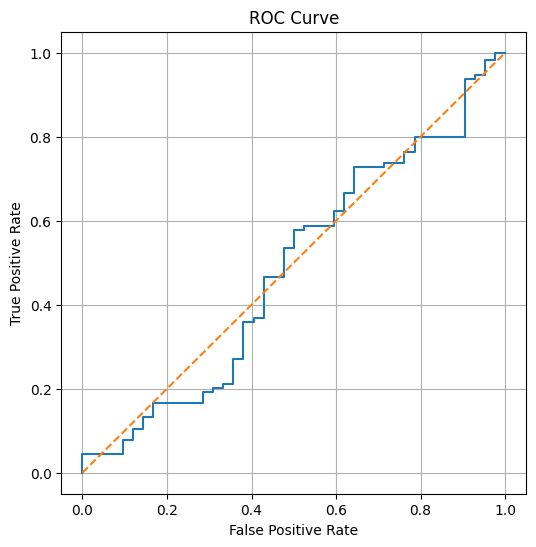

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(y_true, probs)
print("ROC-AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_true, probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

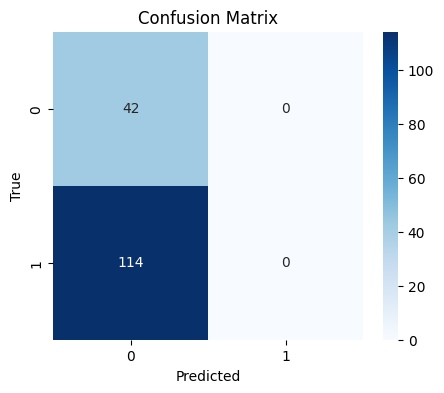

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Assess performance over qubits

In [25]:
def build_qc(n_qubits):
    qc = QuantumCircuit(n_qubits)

    # input parameters x0, x1, ...
    input_params = [Parameter(f"x{i}") for i in range(n_qubits)]

    # trainable parameters θ0, θ1, ...
    theta_params = [Parameter(f"θ{i}") for i in range(n_qubits)]

    # Angle encoding
    for i in range(n_qubits):
        qc.ry(input_params[i], i)

    # Variational layer
    for i in range(n_qubits):
        qc.rx(theta_params[i], i)

    # Entanglement layer
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)

    return qc, input_params, theta_params

In [26]:
class QiskitQuantumLayer(nn.Module):
    def __init__(self, n_qubits, qc, input_params, theta_params):
        super().__init__()
        self.n_qubits = n_qubits
        self.qc = qc
        self.input_params = input_params
        self.theta_params = theta_params

        self.params = nn.Parameter(torch.randn(n_qubits))
        self.estimator = Estimator()

        # Z on each qubit
        self.observables = [
            SparsePauliOp("".join("Z" if j == i else "I" for j in range(n_qubits)))
            for i in range(n_qubits)
        ]

    def forward(self, x):
        outs = []
        for sample in x:
            pdict = {}

            for i,p in enumerate(self.input_params):
                pdict[p] = float(sample[i])

            for i,p in enumerate(self.theta_params):
                pdict[p] = float(self.params[i])

            circuit = self.qc.assign_parameters(pdict)

            circuits = [circuit] * self.n_qubits
            job = self.estimator.run(circuits, self.observables)
            result = job.result().values
            outs.append(result)

        return torch.tensor(outs, dtype=torch.float32)

In [27]:
class HybridModel(nn.Module):
    def __init__(self, n_qubits, qc, input_params, theta_params, n_classes):
        super().__init__()
        self.quantum = QiskitQuantumLayer(n_qubits, qc, input_params, theta_params)
        self.fc = nn.Linear(n_qubits, n_classes)

    def forward(self, x):
        return self.fc(self.quantum(x))

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test) 
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()   # positive class prob
        preds = logits.argmax(dim=1).cpu().numpy()

    y_true = y_test.cpu().numpy()

    # Confusion matrix
    cm = confusion_matrix(y_true, preds)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    return preds, probs, cm, (fpr, tpr, roc_auc)

In [29]:
import seaborn as sns

def plot_confusion_matrix(cm, qubits, class_names=["malignant", "normal/benign"]):
    plt.figure(figsize=(5, 4))
    
    # Normalize for percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt=".2f", 
        cmap="Blues", 
        cbar=True, 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(f"Confusion Matrix – {qubits} qubits")
    plt.tight_layout()
    plt.show()

In [30]:
def plot_roc(fpr_tpr_auc, qubits):
    fpr, tpr, roc_auc = fpr_tpr_auc
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {qubits} qubits")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def train_and_evaluate_qubits(n_qubits, 
                              X_train_flat, X_test_flat, 
                              y_train, y_test, 
                              num_epochs=10,
                              random_state=42):
    
    # random state 42 for reproducibility
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    
    # print update
    print(f"\n===== Training {n_qubits} Qubits =====")

    # apply PCA and prepare tensors for pytorch input
    pca = PCA(n_components=n_qubits, random_state= random_state)
    X_train_pca = torch.tensor(pca.fit_transform(X_train_flat), dtype=torch.float32)
    X_test_pca  = torch.tensor(pca.transform(X_test_flat), dtype=torch.float32)

    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    # build the quantum circuit and create an instance of the hybrid model
    qc, input_params, theta_params = build_qc(n_qubits)
    n_classes = len(np.unique(y_train))
    model = HybridModel(n_qubits, qc, input_params, theta_params, n_classes)

    # define loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    batch_size = 16 # Take 16 samples → run them through the model → compute loss → update weights

   # training loop
    for epoch in range(num_epochs):
        model.train()
        perm = torch.randperm(len(X_train_pca))

        for i in range(0, len(perm), batch_size):
            idx = perm[i:i+batch_size]
            Xb = X_train_pca[idx]
            yb = y_train_t[idx]

            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Loss = {loss.item():.4f}")

   # performance evaluation
    preds, probs, cm, roc_info = evaluate_model(model, X_test_pca, y_test_t)

    acc = (preds == y_test).mean()

    print(f"Accuracy ({n_qubits} qubits): {acc:.4f}")

    plot_confusion_matrix(cm, n_qubits)
    plot_roc(roc_info, n_qubits)
    
    # return results as a dicitionary
    return {
        "accuracy": acc,
        "confusion_matrix": cm,
        "roc_auc": roc_info[2]
    }



===== Training 1 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_4581/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()
/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_4581/3724193794.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor(outs, dtype=torch.float32)


Epoch 1/15 | Loss = 0.3946
Epoch 2/15 | Loss = 0.3268
Epoch 3/15 | Loss = 0.8110
Epoch 4/15 | Loss = 0.3298
Epoch 5/15 | Loss = 0.8321
Epoch 6/15 | Loss = 0.3039
Epoch 7/15 | Loss = 0.2824
Epoch 8/15 | Loss = 0.8728
Epoch 9/15 | Loss = 0.8131
Epoch 10/15 | Loss = 0.3237
Epoch 11/15 | Loss = 0.8367
Epoch 12/15 | Loss = 1.3454
Epoch 13/15 | Loss = 1.2718
Epoch 14/15 | Loss = 0.3634
Epoch 15/15 | Loss = 0.3056
Accuracy (1 qubits): 0.7308


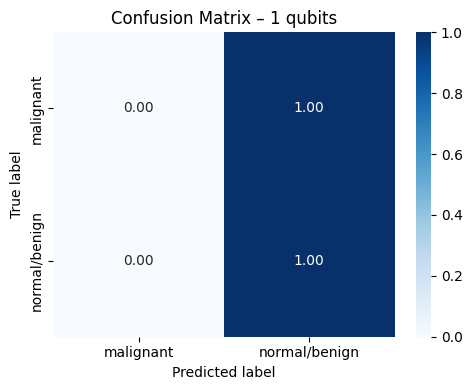

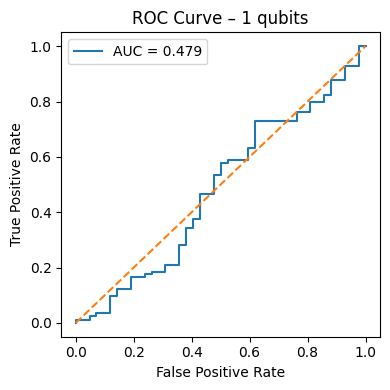


===== Training 2 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_4581/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/15 | Loss = 0.4789
Epoch 2/15 | Loss = 0.7809
Epoch 3/15 | Loss = 0.4630
Epoch 4/15 | Loss = 0.7085
Epoch 5/15 | Loss = 0.4183
Epoch 6/15 | Loss = 0.3582
Epoch 7/15 | Loss = 1.3027
Epoch 8/15 | Loss = 0.2966
Epoch 9/15 | Loss = 0.3565
Epoch 10/15 | Loss = 0.2861
Epoch 11/15 | Loss = 0.8365
Epoch 12/15 | Loss = 0.7259
Epoch 13/15 | Loss = 0.3261
Epoch 14/15 | Loss = 0.2989
Epoch 15/15 | Loss = 0.3252
Accuracy (2 qubits): 0.7308


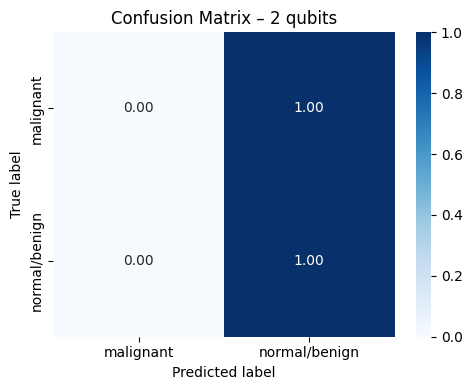

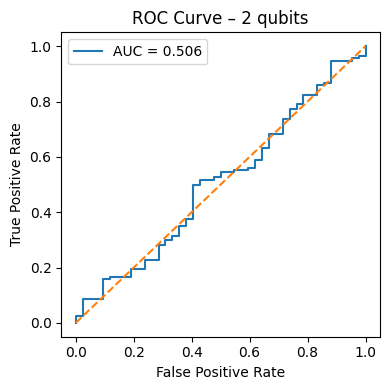


===== Training 5 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_4581/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/15 | Loss = 0.8084
Epoch 2/15 | Loss = 0.7454
Epoch 3/15 | Loss = 0.3387
Epoch 4/15 | Loss = 0.8556
Epoch 5/15 | Loss = 0.2557
Epoch 6/15 | Loss = 0.2980
Epoch 7/15 | Loss = 0.8870
Epoch 8/15 | Loss = 0.2962
Epoch 9/15 | Loss = 0.2240
Epoch 10/15 | Loss = 0.3078
Epoch 11/15 | Loss = 0.3314
Epoch 12/15 | Loss = 0.3622
Epoch 13/15 | Loss = 0.4708
Epoch 14/15 | Loss = 0.7390
Epoch 15/15 | Loss = 1.4456
Accuracy (5 qubits): 0.7372


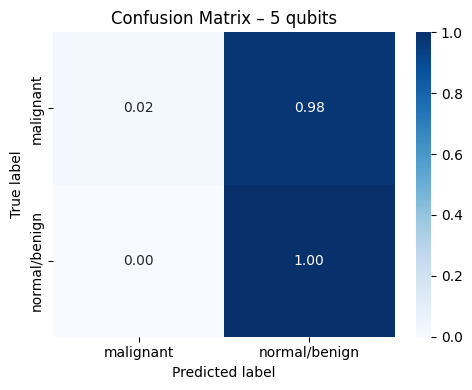

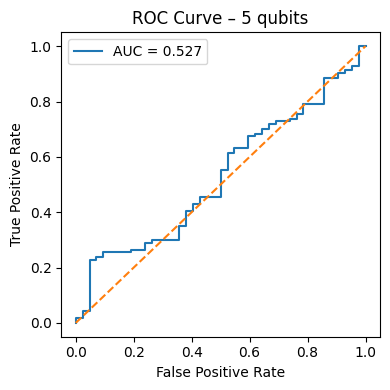


===== Training 10 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_4581/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/15 | Loss = 0.4750
Epoch 2/15 | Loss = 0.7676
Epoch 3/15 | Loss = 1.2383
Epoch 4/15 | Loss = 0.5650
Epoch 5/15 | Loss = 0.7151
Epoch 6/15 | Loss = 0.4017
Epoch 7/15 | Loss = 0.7767
Epoch 8/15 | Loss = 0.9029
Epoch 9/15 | Loss = 0.2302
Epoch 10/15 | Loss = 0.4236
Epoch 11/15 | Loss = 1.1847
Epoch 12/15 | Loss = 0.7647
Epoch 13/15 | Loss = 0.2698
Epoch 14/15 | Loss = 0.2774
Epoch 15/15 | Loss = 1.3350
Accuracy (10 qubits): 0.7308


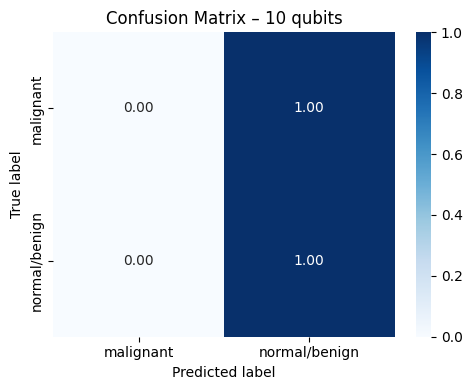

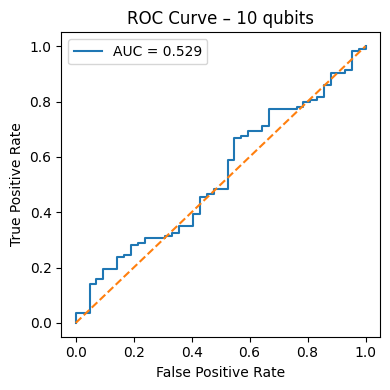


===== Training 15 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_4581/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/15 | Loss = 0.5057
Epoch 2/15 | Loss = 0.8051
Epoch 3/15 | Loss = 0.7504
Epoch 4/15 | Loss = 0.2990
Epoch 5/15 | Loss = 0.3143
Epoch 6/15 | Loss = 0.6957
Epoch 7/15 | Loss = 0.8883
Epoch 8/15 | Loss = 0.7933
Epoch 9/15 | Loss = 1.2909
Epoch 10/15 | Loss = 1.5417
Epoch 11/15 | Loss = 0.3461
Epoch 12/15 | Loss = 1.2522
Epoch 13/15 | Loss = 0.3356
Epoch 14/15 | Loss = 0.3168
Epoch 15/15 | Loss = 0.8254
Accuracy (15 qubits): 0.7308


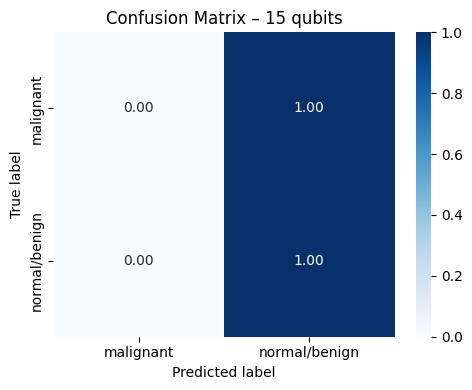

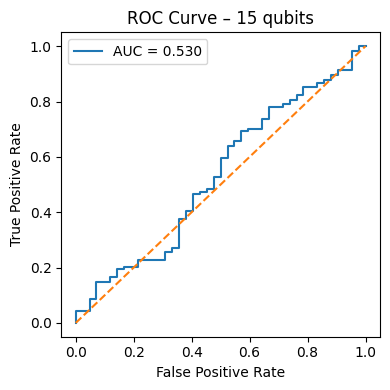


=== Summary ===
1 qubits → Acc=0.7308, AUC=0.4791
2 qubits → Acc=0.7308, AUC=0.5061
5 qubits → Acc=0.7372, AUC=0.5274
10 qubits → Acc=0.7308, AUC=0.5290
15 qubits → Acc=0.7308, AUC=0.5301


In [32]:
qubit_list = [1, 2, 5, 10, 15]
results = {}

for q in qubit_list:
    results[q] = train_and_evaluate_qubits(
        q,
        X_train_flat, X_test_flat,
        y_train, y_test,
        num_epochs=15
    )

print("\n=== Summary ===")
for q, r in results.items():
    print(f"{q} qubits → Acc={r['accuracy']:.4f}, AUC={r['roc_auc']:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, qubits, class_names=["malignant", "benign/normal"]):
    plt.figure(figsize=(5, 4))
    
    # Heatmap with counts only
    sns.heatmap(
        cm, 
        annot=True,        # show numbers
        fmt="d",           # integer format
        cmap="Blues", 
        cbar=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        square=True
    )
    
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(f"Confusion Matrix – {qubits} qubits")
    plt.tight_layout()
    plt.show()


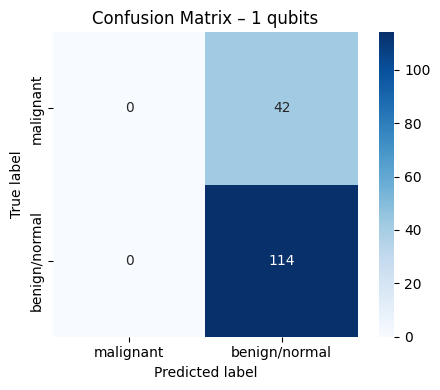

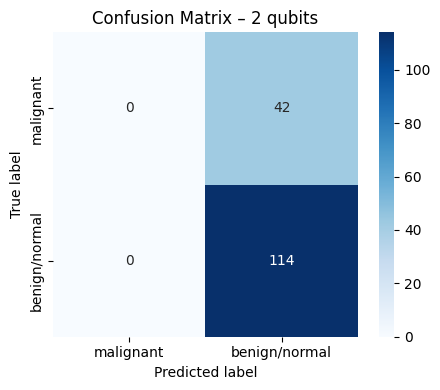

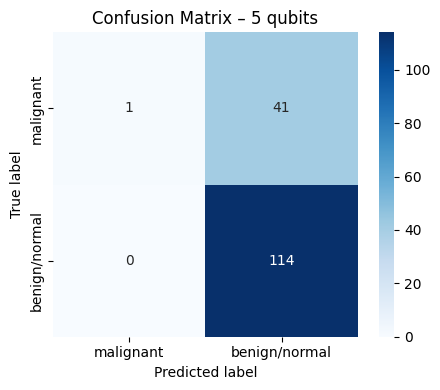

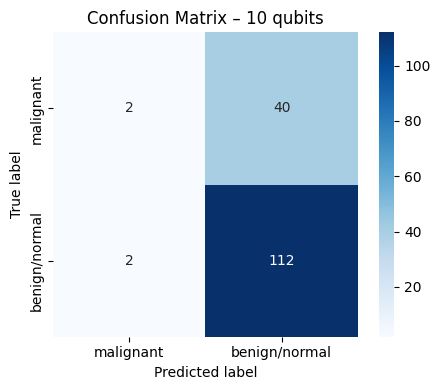

In [61]:
for q, r in results.items():
    plot_confusion_matrix(r["confusion_matrix"], qubits=q)

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_comparison(results, class_name="malignant vs benign/normal"):
    plt.figure(figsize=(6, 6))
    
    for q, r in results.items():
        # Get probabilities and true labels
        probs = r.get("probs")  # shape: (n_samples, n_classes)
        y_true = r.get("y_true")
        
        if probs is None or y_true is None:
            print(f"Skipping {q} qubits: ROC data missing")
            continue
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, probs[:, 1])  # assuming class 1 is positive
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f"{q} qubits (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Comparison – {class_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [66]:
results[q]["probs"] = probs  # predicted probabilities for each class
results[q]["y_true"] = y_test  # true labels
plot_roc_comparison(results)

Skipping 1 qubits: ROC data missing
Skipping 2 qubits: ROC data missing
Skipping 5 qubits: ROC data missing


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 600x600 with 0 Axes>

In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_comparison(results, class_name="malignant vs benign/normal"):
    plt.figure(figsize=(6, 6))
    
    for q, r in results.items():
        probs = r.get("probs")  # should be 1D: probability for positive class
        y_true = r.get("y_true")
        
        if probs is None or y_true is None:
            print(f"Skipping {q} qubits: ROC data missing")
            continue
        
        probs = probs.flatten()  # ensure 1D
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f"{q} qubits (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Comparison – {class_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [71]:
for q, r in results.items():
    # probs = softmax outputs for positive class (class 1)
    logits = r["logits"]           # raw model outputs (n_samples, n_classes)
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    r["probs"] = probs
    r["y_true"] = y_test

KeyError: 'logits'

In [72]:
for q, r in results.items():
    # probs = softmax outputs for positive class (class 1)
    logits = r["logits"]           # raw model outputs (n_samples, n_classes)
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    r["probs"] = probs
    r["y_true"] = y_test

KeyError: 'logits'

In [73]:
return {
    "accuracy": acc,
    "confusion_matrix": cm,
    "roc_auc": roc_info[2],
    "logits": logits
}

SyntaxError: 'return' outside function (4215937966.py, line 1)

In [74]:
def plot_accuracy_comparison(results):
    qubits = list(results.keys())
    accuracies = [results[q]['accuracy'] for q in qubits]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(qubits, accuracies, color='skyblue', edgecolor='black')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}", 
                 ha='center', va='bottom', fontsize=10)
    
    plt.xticks(qubits)
    plt.ylim(0, 1)
    plt.xlabel("Number of Qubits")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy Comparison Across Qubit Counts")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


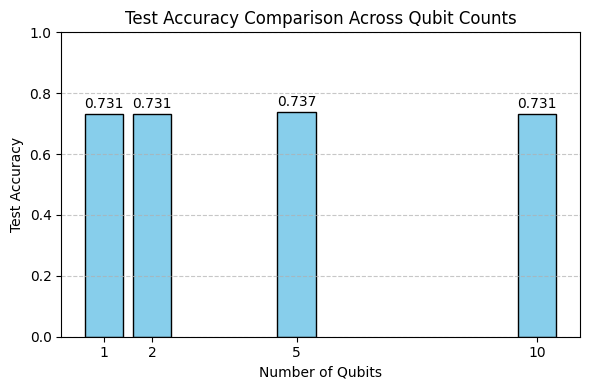

In [75]:
plot_accuracy_comparison(results)

In [76]:
def plot_all_roc(results):
    plt.figure(figsize=(6, 6))

    for q, r in results.items():
        if "probs" not in r or "y_true" not in r:
            continue
        
        y_true = r["y_true"]
        probs = r["probs"]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"{q} qubits (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison Across Qubits")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



In [77]:
for q, r in results.items():
    logits = r["logits"]  # raw model outputs
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    r["probs"] = probs
    r["y_true"] = y_test  # true labels

KeyError: 'logits'

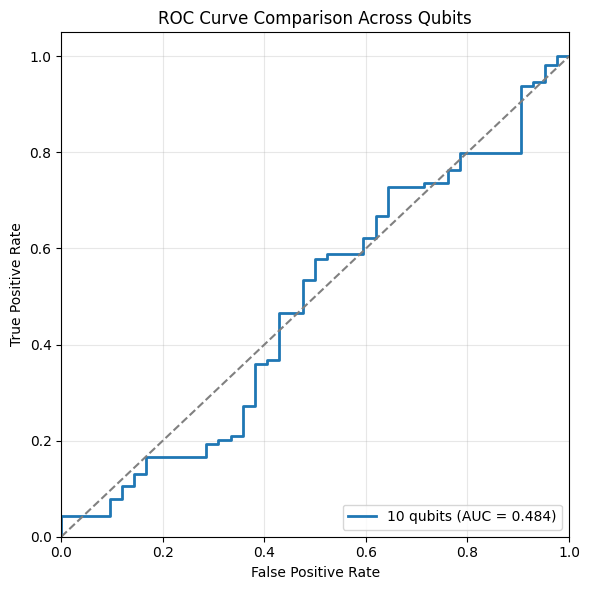

In [78]:
plot_all_roc(results)

what is batch size, what are logits

Take 16 samples → run them through the model → compute loss → update weights

Take the next 16 samples → update weights

Repeat until you’ve gone through all samples (this is one epoch)